In [1]:
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats


In [2]:
# Import data file
data_directory = 'C:/Users/mvmigem/Documents/data/project_1/raw_data/'
dir_list = glob.glob(data_directory+'sub_*/behav/*.csv')


In [3]:
df_list = []
for i in range(len(dir_list)):
    behav_dat = pd.read_csv(dir_list[i])
    df_list.append(behav_dat)

big_df = pd.concat(df_list,ignore_index=True)
big_df= big_df[~(big_df.participant.isin([3,14,20]))]

In [4]:
"""
Counting the amount of raw events
"""
sub_list = big_df['participant'].unique() 
# Step 1: Group by subject, attention, and expectation, and count rows
df_repeated = big_df.loc[np.repeat(big_df.index, 4)].reset_index(drop=True)
df_to_count = df_repeated[~(df_repeated.participant.isin([3,14,20]))]
grouped = df_to_count.groupby(['participant', 'attention', 'expected']).size().reset_index(name='row_count')

# Step 3: Group by attention and expectation, and calculate the mean and standard deviation
stats_per_condition = grouped.groupby(['attention', 'expected'])['row_count'].agg(['mean', 'std']).reset_index()


In [5]:
"""  
Add reaction time and accuracy variables from base date
"""
# add rt and accuracy meassures
def calculate_subtraction(row):
    if row['catch_trial'] != 0:
        relevant_timepoint_col = f"t_stim_{row['catch_trial']}"
        rt =  row['press_time'] - row[relevant_timepoint_col] - 300 # correct for eye-tracking condition delay
        if rt > 3200:
            return np.nan
        return rt
# Apply the function to create the subtraction column
big_df['rt'] = big_df.apply(calculate_subtraction, axis=1)

def accuracy_calc(row):
    if row['catch_trial'] !=0:
        if row['key_pressed'] == 'space':
            if (row['rt'] >= 0) & (row['rt'] <= 1000):
                return 'hit'
            elif row['rt'] < 0:
                return 'false_fire'
            elif row['rt'] > 1000:
                return 'too_slow'
        else:
            return 'false_fire'
    else:
        if row['key_pressed'] == 'space':
            return 'miss'
    return 'correct'

big_df['accuracy'] = big_df.apply(accuracy_calc, axis=1)

# false fire correction for example when response comes in next trial
count_changes = []
for i in range(len(big_df) - 1):
    current_row = big_df.iloc[i]
    next_row = big_df.iloc[i + 1]
    
    if current_row['accuracy'] == 'miss' and next_row['accuracy'] == 'false_fire':
        # Modify current row's accuracy
        big_df.at[i, 'accuracy'] = 'too_slow'
        # Modify next row's accuracy
        big_df.at[i + 1, 'accuracy'] = 'correct'
        count_changes.append(i)


In [6]:
"""
***Aestetics***
"""
# load color palette
my_palette = sns.color_palette().as_hex()
my_palette1 = sns.color_palette("mako")
my_palette1


[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

In [7]:
# Load peak properties of localiser data
peak_properties = pd.read_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_peak_properties.csv')
peak_properties = peak_properties[~(peak_properties.subject.isin([3,14,20]))]
peakch_n =peak_properties['all_pos_peak_channel'].value_counts()


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_33260\2864271155.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( subject_loc_quad, palette= line_colours2, ax=axes[0])
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_33260\2864271155.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( peakch_n, palette= my_palette1,ax=axes[1])
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_33260\2864271155.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(tick_labels, fontdict={'family': 'Segoe UI','size':14})


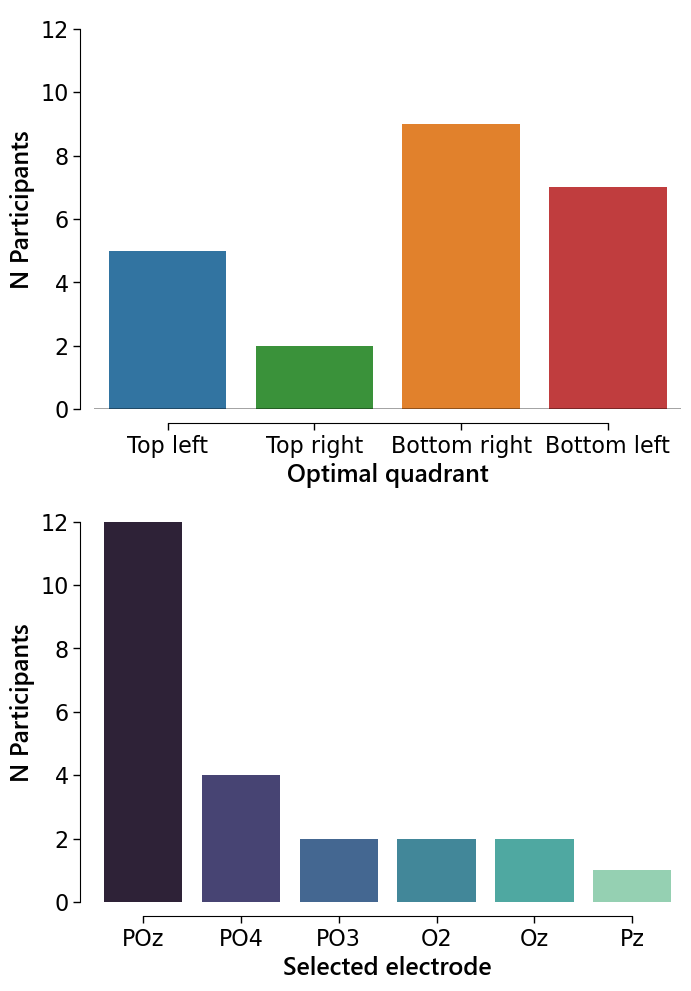

In [8]:
subject_loc_quad = big_df.groupby('participant')['loc_quad'].first().value_counts()

fig, axes = plt.subplots(2,1,figsize=(7, 10),sharey=True,sharex=False)
sns.set_context("paper")

# line_colours1= ['#219EBC','#FFB703']['#8ECAE6','#FB8500','#219EBC','#FFB703']
line_colours2 = line_colours = [my_palette[0],my_palette[2],my_palette[1],my_palette[3]]

sns.barplot( subject_loc_quad, palette= line_colours2, ax=axes[0])
sns.barplot( peakch_n, palette= my_palette1,ax=axes[1])
tick_labels = ['Top left', 'Top right', 'Bottom right','Bottom left']  # Replace ... with additional labels

axes[0].axhline(y=0, lw=1, c='black' )
axes[0].axhline(y=0, lw=1, c='black' )
axes[0].set_ylabel('N Participants', fontdict={'family': 'Segoe UI', 'weight': 'semibold','size':18})
axes[0].set_xlabel('Optimal quadrant', fontdict={'family': 'Segoe UI', 'weight': 'semibold','size':18})
axes[0].set_xticklabels(tick_labels, fontdict={'family': 'Segoe UI','size':14})

axes[1].set_ylabel('N Participants', fontdict={'family': 'Segoe UI', 'weight': 'semibold','size':18})
axes[1].set_xlabel('Selected electrode', fontdict={'family': 'Segoe UI', 'weight': 'semibold','size':18})
# axes[1].set_xticklabels(tick_labels, fontdict={'family': 'Segoe UI','size':14})

axes[0].tick_params(axis='x', labelsize=16)  # Font size for x-axis numbers
axes[0].tick_params(axis='y', labelsize=16) 

# Change the size of the numbers on the axes
axes[1].tick_params(axis='x', labelsize=16)  # Font size for x-axis numbers
axes[1].tick_params(axis='y', labelsize=16) 

sns.despine(offset=10, trim=True)

plt.tight_layout()
plt.show()
fig.savefig('fig_c1_main.png')
plt.show()

In [9]:
palette=my_palette[:4]

In [12]:
df_rt = big_df[big_df['catch_trial'] != 1]
rt_results = df_rt.groupby(['participant','attention','expected'])['rt'].mean().reset_index()

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_33260\1850143923.py:1: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(data= rt_results, x='attention',y='rt',hue='expected',


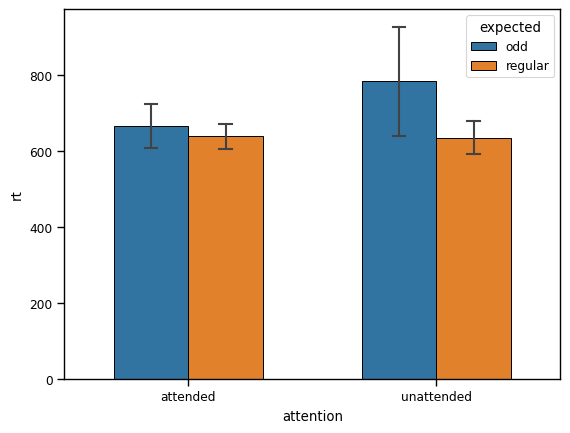

In [14]:
ax = sns.barplot(data= rt_results, x='attention',y='rt',hue='expected',
                 edgecolor= 'black',
                errorbar='se', errwidth= 1.5,
                capsize=.1,width=.6, linewidth=0.7)

In [15]:
sub_grouped = big_df.groupby(['participant','attention'])['rt'].mean()
# sub_grouped = sub_grouped.transform(stats.zscore)
sub_grouped = sub_grouped.unstack().reset_index()
t_statistic, p_value = stats.ttest_rel(sub_grouped['attended'], sub_grouped['unattended'])

In [16]:
# transform for analysis
# Convert to long format
long_df = pd.melt(
    sub_grouped,
    id_vars=['participant'],  # Columns to keep as identifiers
    value_vars=['attended','unattended'],  # Columns to melt
    var_name='attention',  # Name for the new column that will store the condition names
    value_name='rt'  # Name for the new column that will store the values
)

In [9]:
destination_folder = r"C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes/"
long_df.to_csv(destination_folder + "behaviour_rt.csv")

In [17]:
df_acc = big_df[big_df['accuracy'].isin(['hit','miss','too_slow'])]
df_acc['is_correct'] = df_acc['accuracy'] == 'hit'
df_acc_pred = df_acc[df_acc['catch_trial'] != 1]

pred_accuracy = df_acc_pred.groupby(['participant','expected'])['is_correct'].mean()
att_accuracy = df_acc.groupby(['participant','attention'])['is_correct'].mean()


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_33260\1802231395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc['is_correct'] = df_acc['accuracy'] == 'hit'


In [29]:
pred_accuracy.mean()

0.860832585289107

In [22]:
# sub_grouped = sub_grouped.transform(stats.zscore)
sub_grouped = att_accuracy.unstack().reset_index()
t_statistic, p_value = stats.ttest_rel(sub_grouped['attended'], sub_grouped['unattended'])

In [23]:
# sub_grouped = sub_grouped.transform(stats.zscore)
sub_grouped = pred_accuracy.unstack().reset_index()
t_statistic, p_value = stats.ttest_rel(sub_grouped['regular'], sub_grouped['odd'])

In [22]:
from scipy.stats import norm

# Otherwise, infer signal/noise from accuracy:
big_df['is_signal'] = big_df['accuracy'].isin(['hit', 'miss','too_slow'])  # Assume hits/misses = signal trials
big_df['is_noise'] = big_df['accuracy'].isin(['false_fire', 'correct'])

def calculate_dprime(group):
    # Calculate Hit Rate (HR)
    hits = (group['accuracy'] == 'hit').sum()
    signal_trials = group['is_signal'].sum()
    hr = (hits + 0.5) / (signal_trials + 1)
    norm_hr = norm.ppf(hr)

    # Calculate False Alarm Rate (FAR)
    false_alarms = (group['accuracy'] == 'false_fire').sum()
    noise_trials = group['is_noise'].sum()
    far = (false_alarms + 0.5) / (noise_trials +1)
    norm_far = norm.ppf(far)
    
    # Calculate d' (Z-scores) and beta 
    dprime = norm_hr - norm_far
    beta = np.exp((norm_far**2 - norm_hr**2) / 2)

    return pd.Series({
        'hits': hits,
        'misses': (group['accuracy'] == 'miss').sum(),
        'too_slow': (group['accuracy'] == 'too_slow').sum(),
        'false_alarms': false_alarms,
        'signal_trials': signal_trials,
        'noise_trials': noise_trials,
        'hit_rate': hr,
        'false_alarm_rate': far,
        'dprime': dprime,
        'beta':beta
    })

big_df = big_df.rename(columns={'expected': 'expectation'})

df_acc_pred = big_df[big_df['catch_trial'] != 1]

# Group by participant and condition, then apply d' calculation
acc_results = df_acc_pred.groupby(['participant', 'expectation','attention']).apply(calculate_dprime).reset_index()
acc_results = acc_results[acc_results['signal_trials'] > 0] # remove cells where no signal trials occured
acc_aggr = df_acc_pred.groupby([ 'expectation','attention']).apply(calculate_dprime).reset_index()

acc_mean_results = df_acc_pred.groupby(['participant','attention']).apply(calculate_dprime).reset_index()
acc_mean_results['miss_rate'] = (acc_mean_results['too_slow'] + acc_mean_results['misses']) / acc_mean_results['signal_trials']

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_33260\3141397237.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_results = df_acc_pred.groupby(['participant', 'expectation','attention']).apply(calculate_dprime).reset_index()
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_33260\3141397237.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_aggr = df_acc_pred.groupby([ 'expectation','attention']).apply(calcu

In [31]:
# acc_mean_results[acc_mean_results['attention'] == 'attended']['miss_rate'].mean()
# acc_mean_results[acc_mean_results['attention'] == 'attended']['miss_rate'].std()
# acc_mean_results[acc_mean_results['attention'] == 'unattended']['miss_rate'].mean()
acc_mean_results[acc_mean_results['attention'] == 'unattended']['miss_rate'].std()


np.float64(0.18778033749721293)

In [24]:
destination_folder = r"C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes/"
acc_mean_results.to_csv(destination_folder + "behaviour_acc.csv")

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_4208\2173802747.py:1: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(data= acc_results, y = 'hit_rate', x = 'attention', hue='expectation',


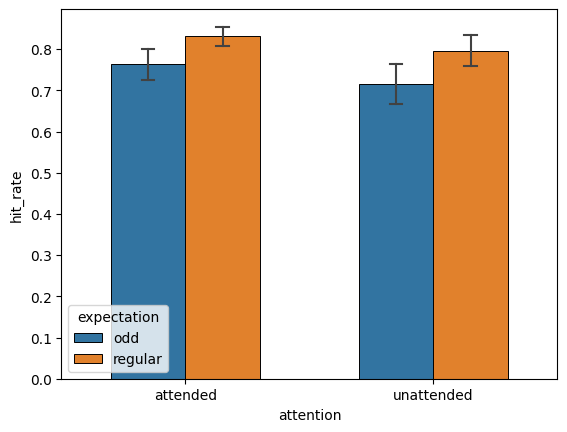

In [15]:
ax = sns.barplot(data= acc_results, y = 'hit_rate', x = 'attention', hue='expectation',
                 edgecolor= 'black',
                errorbar='se', errwidth= 1.5,
                capsize=.1,width=.6, linewidth=0.7)

In [ ]:
excuded_pp = [3,14,20]
pp_info = big_df.groupby('participant').first().reset_index()
pp_info = pp_info[~pp_info['participant'].isin(excuded_pp)]



In [ ]:
pp_info['handed'].value_counts()

In [ ]:
""" 
Ugh accuracies
"""
